In the [last post][last] we constructed an alternative momentum operator using *eigendecomposition*. 
This momentum operator gives the correct energy-momentum dispersion relation for the
free particle in the discretized space. In this post we will now compare this "non-local" operator
to the simple local $\hat p^2$ operator for eigenenergies of the harmonic oscillator.

[last]: https://znswanderer.github.io/physics/Discrete-Dispersion/

First, import the usual python packages:

In [4]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We want to compare the local momentum operator and the non-local operator from the eigendecomposition 
for the problem of the simple harmonic oscillator (SHO). In order to not mix up the various parameters, coordinates
and operators for both, we bundle them up in a python class.

The base class for both approaches is given as:

In [6]:
class QM_SHO:
    name = "Base class for QM SHO"

    def __init__(self, L, N, omega=1, hbar=1, mass=1):
        self.hbar = hbar
        self.mass = mass
        self.omega = omega
        # The SHO is confined to a space of size L
        self.L = L
        # The resolution of the discretization of (position) space
        self.N = N
        self.x = np.linspace(0, L, N, endpoint=False) - L/2
        self.dx = np.diff(self.x)[0]

### Local $\textbf{P2}$ Operator

Now we define a sub-class, which handles the discretization with a local matrix operator $\textbf{P2}$
as the discretized version of the $\hat p^2$ operator. *Local* here means, that for calculating
the second derivative we only use the nearest neighbour points in the spatial domain.

By keeping the $\textbf{P2}$ matrix local we can use *sparse* matrices, that are more efficient 
to handle by a computer. The position operator $\textbf{X}$ is very simple and has been
discussed [before][x_op]. The form of the local $\textbf{P2}$ matrix has been given in [this][p_op]
blog post.

With this we can now define the class, that uses the local operators: 

[x_op]: https://znswanderer.github.io/physics/Regarding-Commutators/
[p_op]: https://znswanderer.github.io/physics/Discrete/

In [7]:
class QM_SHO_Local(QM_SHO):
    name = "Local P2 operator"
    
    def D2(self):
        # The second order difference operator in periodic boundary conditions
        return sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, self.N-1, -self.N+1], 
                            shape=(self.N, self.N)) / self.dx**2
    
    def X(self):
        """The position space operator"""
        return sparse.diags([self.x], [0])    
    
    def Hamiltonian(self):
        D2 = self.D2()
        X = self.X()
        return (-(self.hbar**2 / (2 * self.mass)) * D2 + 0.5 * self.mass * self.omega**2 * (X @ X))
    
    def eigh(self):
        return linalg.eigsh(self.Hamiltonian(), k=self.N - 1, which='SM')

For convenience I define a small function to display eigenfunctions of a system:

In [8]:
def plot_eigenfunctions(qms, ns, figsize=(8,6)):
    """Plot eigenfunctions of all systems in qms. The number of
    the plotted eigenfunctions are given by the list ns.
    """
    plt.figure(figsize=figsize)
    for qm in qms:
        eigvals, eigvecs = qm.eigh()
        for n in ns:
            if len(qms) == 1:
                label = r"$E_{%d}/\hbar \omega = %.3f$" % (n, eigvals[n]/qm.omega)
            else:
                label = qm.name + ", $\psi_{%d}$" % n
            plt.plot(qm.x, eigvecs.T[n].real, label=label)

    plt.xlabel("$x$")
    plt.ylabel(r"$\psi$")
    plt.legend(fontsize=12)
    plt.title(qm.name)

Let's plot some eigenfunctions!

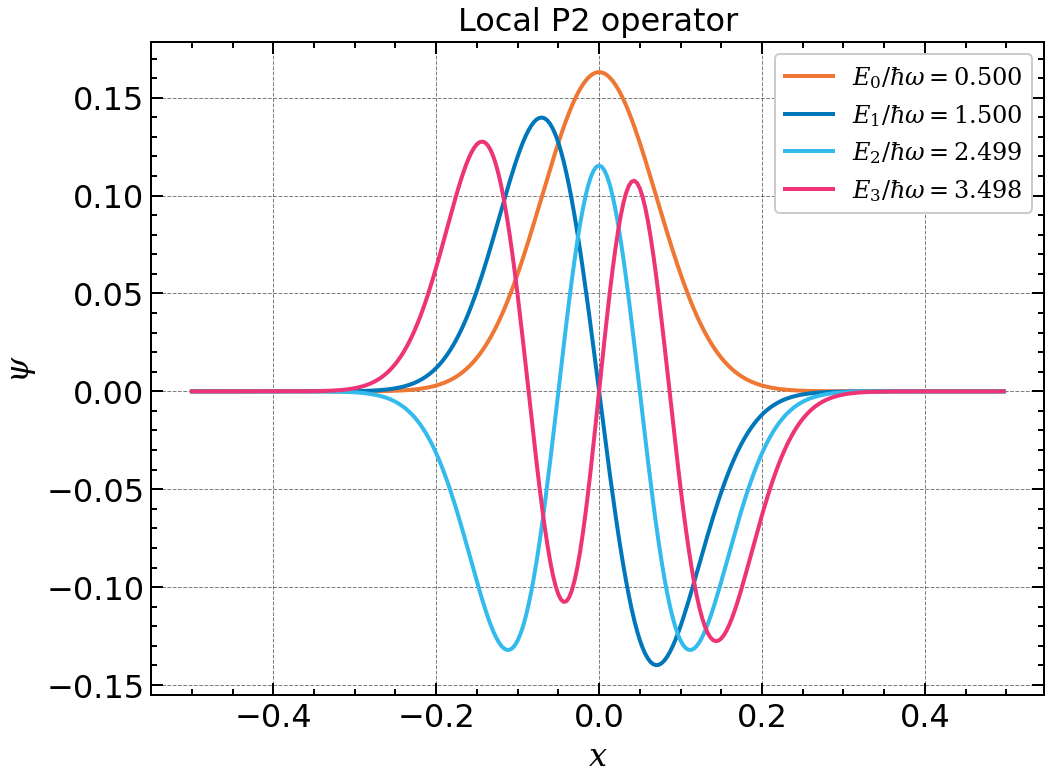

In [9]:
qm = QM_SHO_Local(L=1, N=300, omega=200)
plot_eigenfunctions([qm], range(4))

One can clearly see, that the eigenfunctions found with the discrete local operator
resemble the functions found by the [analytic solution][qm_sho] for the continuous 
spatial domain. But the energy values start to differ from the analytic solution

$$
E_n = \hbar \omega \left( n + \frac{1}{2} \right)
$$

for higher $n$. This is clearly a result of the discretization and can be resolved if
we use a finer spatial resolution:

[qm_sho]: https://znswanderer.github.io/physics/Harmonic-Oscillator-SymPy/

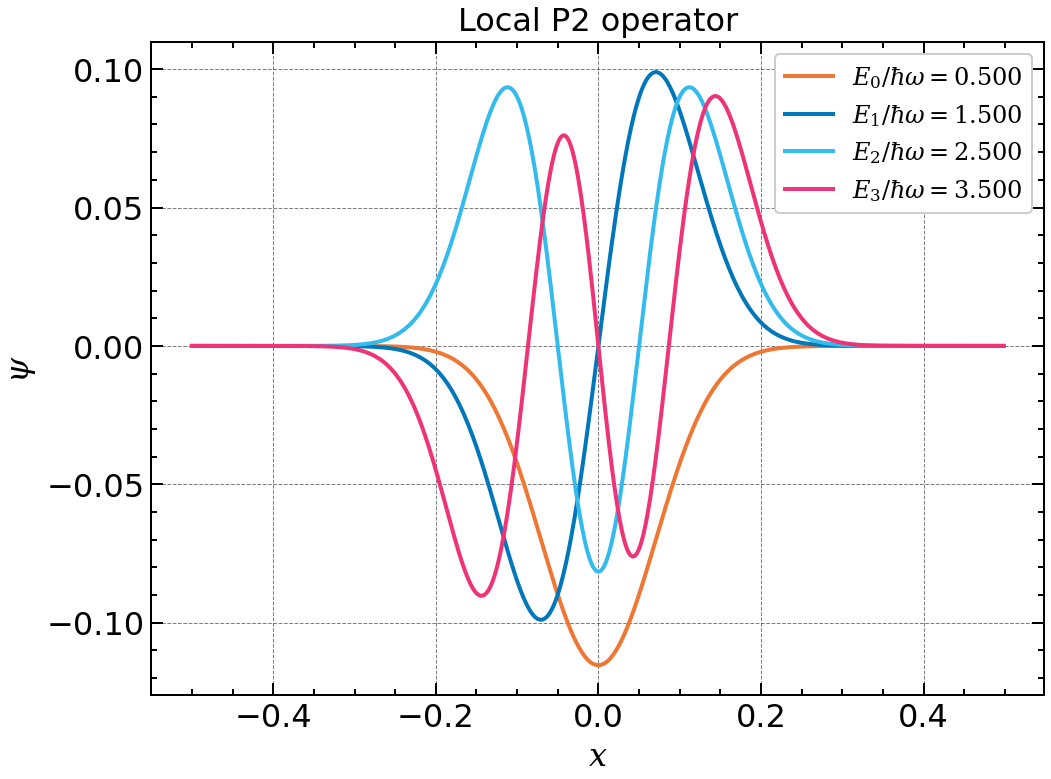

In [10]:
qm = QM_SHO_Local(L=1, N=600, omega=200)
plot_eigenfunctions([qm], range(4))

Here we now get the correct energy values, but it is surely to be expected, that for
higher $n$-values than $n=3$ the energy values will be differ again. But in principle 
we can adjust the spatial resolution $N$.

*(The fact, that some eigenfunctions in the graph for $N=600$ are the negative of 
the functions for $N=300$ is no matter of concern, because if $\psi(x)$ is an 
eigenfunction, so is $-\psi(x)$. Both are in the same [equivalence class][eq_class])*

[eq_class]: https://en.wikipedia.org/wiki/Equivalence_class

### Non-local Linear Dispersion Momentum Operator

Next we define the system with the non-local momentum operator, which was discussed 
in the [last blog post][nonlocal]:

[nonlocal]: https://znswanderer.github.io/physics/Discrete-Dispersion/

In [11]:
class QM_SHO_Nonlocal(QM_SHO):
    name = "Non-local P2 operator"

    # A function to construct the n-th eigenvector of the momentum operator
    def psi_n(self, n):
        """Returns ($E_n$, $k_n$, $\psi_n$)
        """
        k_n = 2 * np.pi * n / self.L
        E_n = k_n**2 * self.hbar**2 / (2 * self.mass)
        psi = np.exp(1j * k_n * self.x)
        psi /= np.sqrt(psi.T.conj() @ psi * self.dx)
        return E_n, k_n, psi
    
    def target_eigh(self):
        kns = []
        pns = []
        for n in range(-self.N//2, self.N//2):
            _, kn, pn = self.psi_n(n)
            kns.append(kn)
            pns.append(pn)
        return kns, pns
    
    def Pd(self):
        # from https://znswanderer.github.io/physics/Discrete-Dispersion/
        kns, pns = self.target_eigh()

        # Instead of Q we will construct Q_inv, that is Q^{-1}, because we
        # can simply stack rows of eigenvectors
        Q_inv = np.array([v.T.conj() for v in pns])
        Q = Q_inv.T.conj()
        Lambda = np.diag(kns)
        # calculate P = Q \Lambda Q^{-1}
        # we also must include the resolution dx in order to get correct scaling
        Pd = Q @ Lambda @ Q_inv * self.dx         
        return Pd

    def X(self):
        """The position space operator"""
        return np.diag(self.x)    

    def Hamiltonian(self):
        X = self.X()
        Pd = self.Pd()
        return (self.hbar**2 / (2 * self.mass)) * (Pd @ Pd) + 0.5 * self.mass * self.omega**2 * (X @ X)
    
    def eigh(self):
        return np.linalg.eigh(self.Hamiltonian())

The used momentum operator yields the correct energy-momentum dispersion relation in contrast
to the local $\textbf{P2}$ operator above, so we would expect that the energy eigenvalues
match the analytic solutions for smaller spatial resolution. If we now use the resolution $N=300$,
for which the local operator version showed discrepancies, we find that indeed the energy values
are correct:

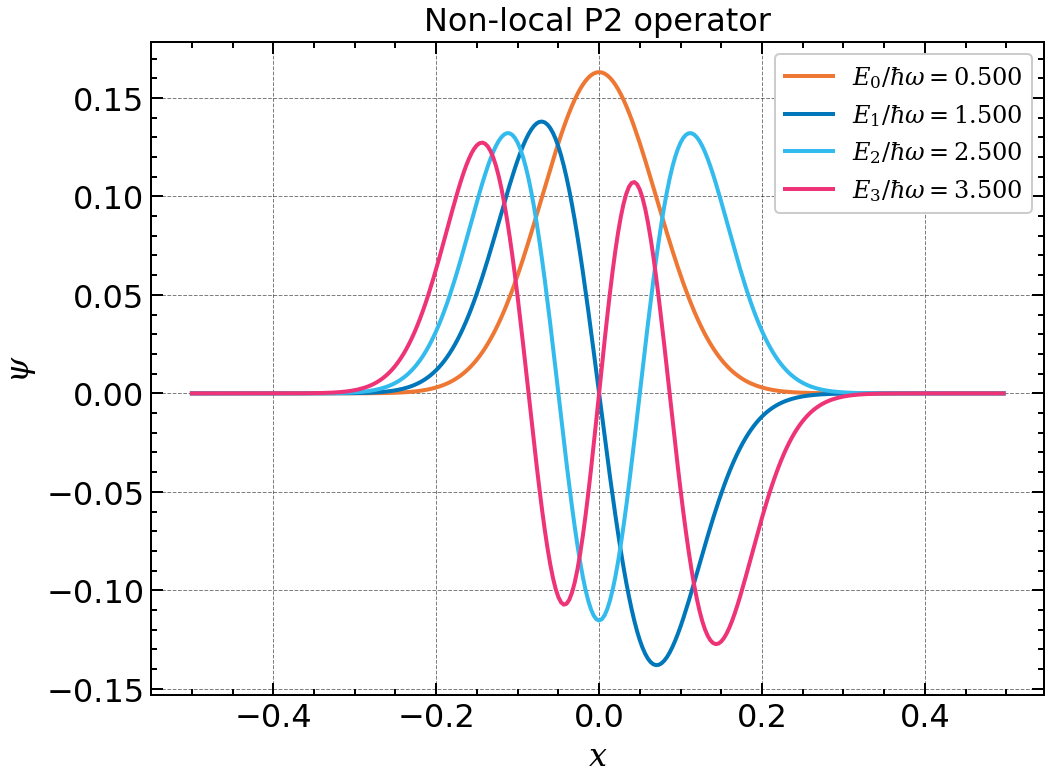

In [12]:
qm = QM_SHO_Nonlocal(L=1, N=300, omega=200)
plot_eigenfunctions([qm], range(4))

Even if we reduce the spatial resolution so much, that the plotted functions show signs of the
discretization, the energy values are still perfectly fine:

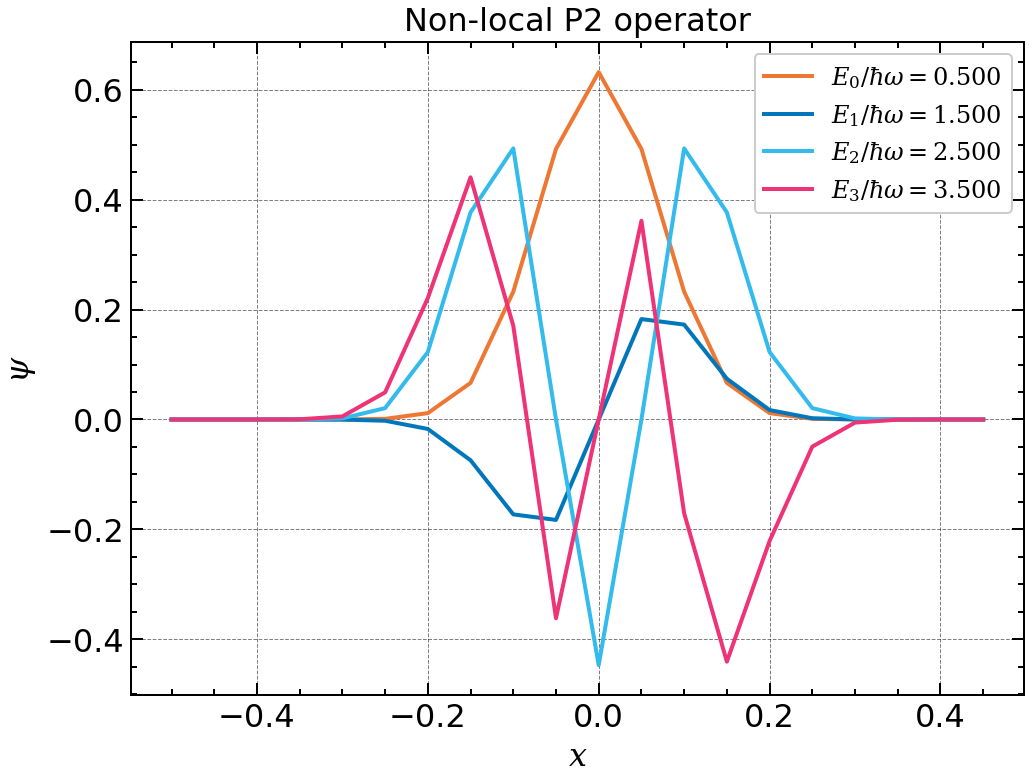

In [13]:
qm = QM_SHO_Nonlocal(L=1, N=20, omega=200)
plot_eigenfunctions([qm], range(4))

## A closer look at the energy eigenvalues

As we expect the energy eigenvalues to differ from the analytic solution for higher $n$, it is 
a good idea to examine this in detail:

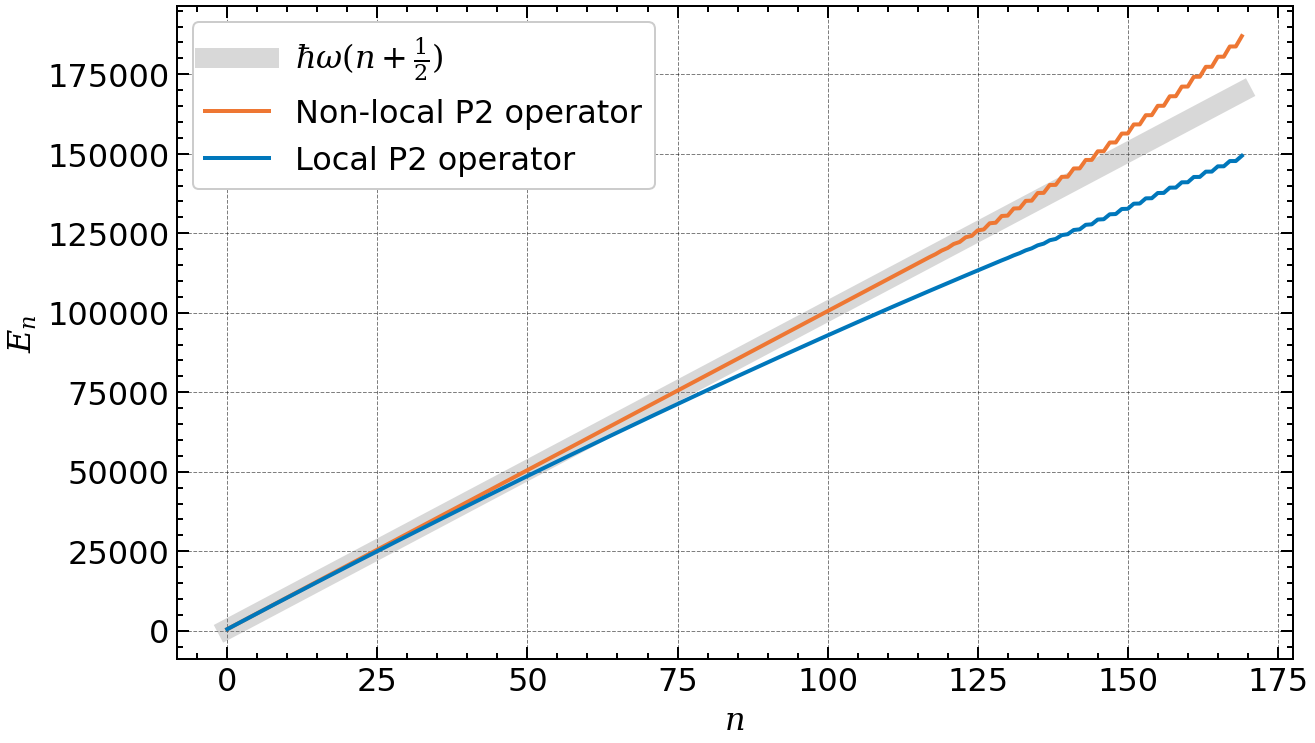

In [14]:
plt.figure(figsize=(10,6))

omega = 1000
max_n = 170
ns = np.arange(0, max_n)
plt.plot(ns,(ns + 0.5) * omega , color="grey", linewidth=10, label=r'$\hbar \omega (n + \frac{1}{2})$', alpha=0.3)

for klass in [QM_SHO_Nonlocal, QM_SHO_Local]:
    qm = klass(L=1, N=300, omega=omega)
    eigvals, _ = qm.eigh()
    plt.plot(ns, eigvals[:max_n], label=qm.name)

plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

In the plot above we have given $E_n$ for the local and non-local operators and compared
them with the analytic solution (thick grey line).
One can see, that the non-local operator follows the analytic solution pretty good
for most of the $n$-values, whereas the local operator deviates from the correct values
with larger $n$ as expected.

But for $n > 125$ the non-local operator also no longer shows the correct energy
values. What is happening here?

To examine this question we use a smaller $\omega$ where this phenomenon sets in
for smaller $n$:

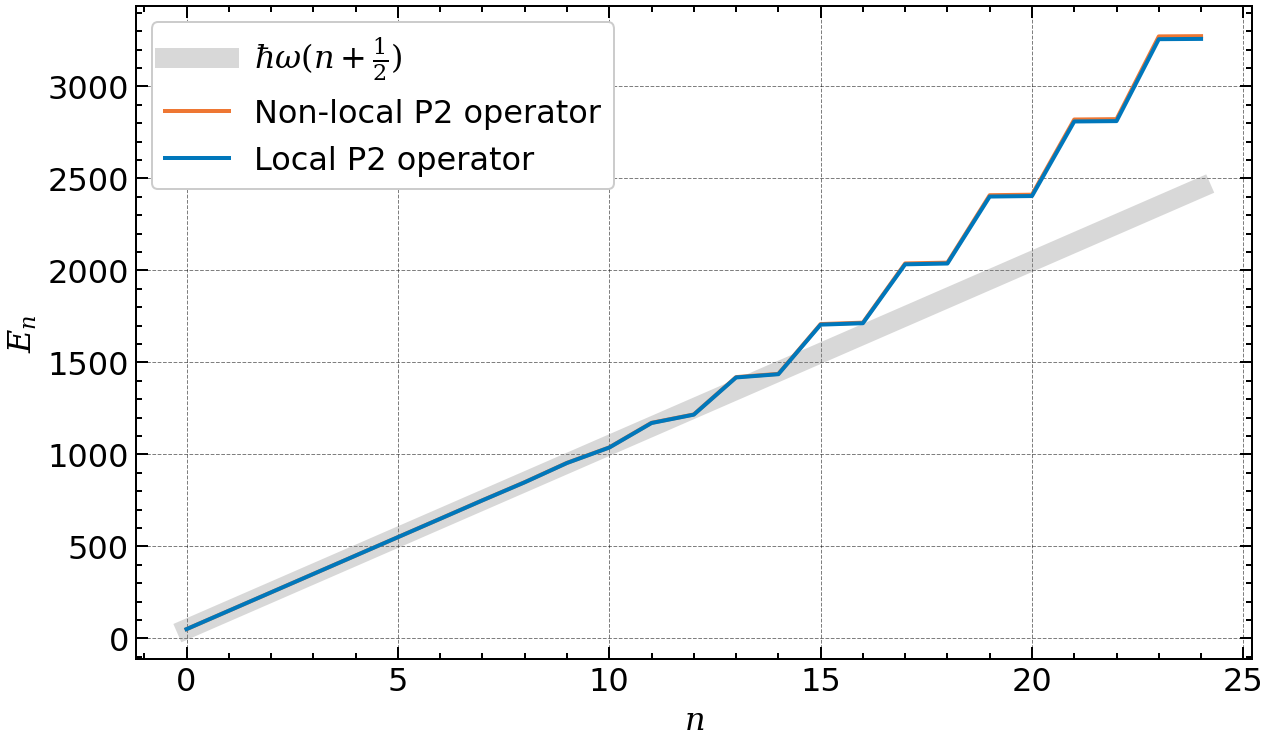

In [15]:
plt.figure(figsize=(10,6))

omega = 100
max_n = 25
ns = np.arange(0, max_n)
plt.plot(ns,(ns + 0.5) * omega , color="grey", linewidth=10, label=r'$\hbar \omega (n + \frac{1}{2})$', alpha=0.3)

for klass in [QM_SHO_Nonlocal, QM_SHO_Local]:
    qm = klass(L=1, N=300, omega=omega)
    eigvals, _ = qm.eigh()
    plt.plot(ns, eigvals[:max_n], label=qm.name)

plt.xlabel("$n$")
plt.ylabel("$E_n$")
plt.legend();

Here the problems start at $n \approx 8$. Let's take a look at some eigenfunctions!

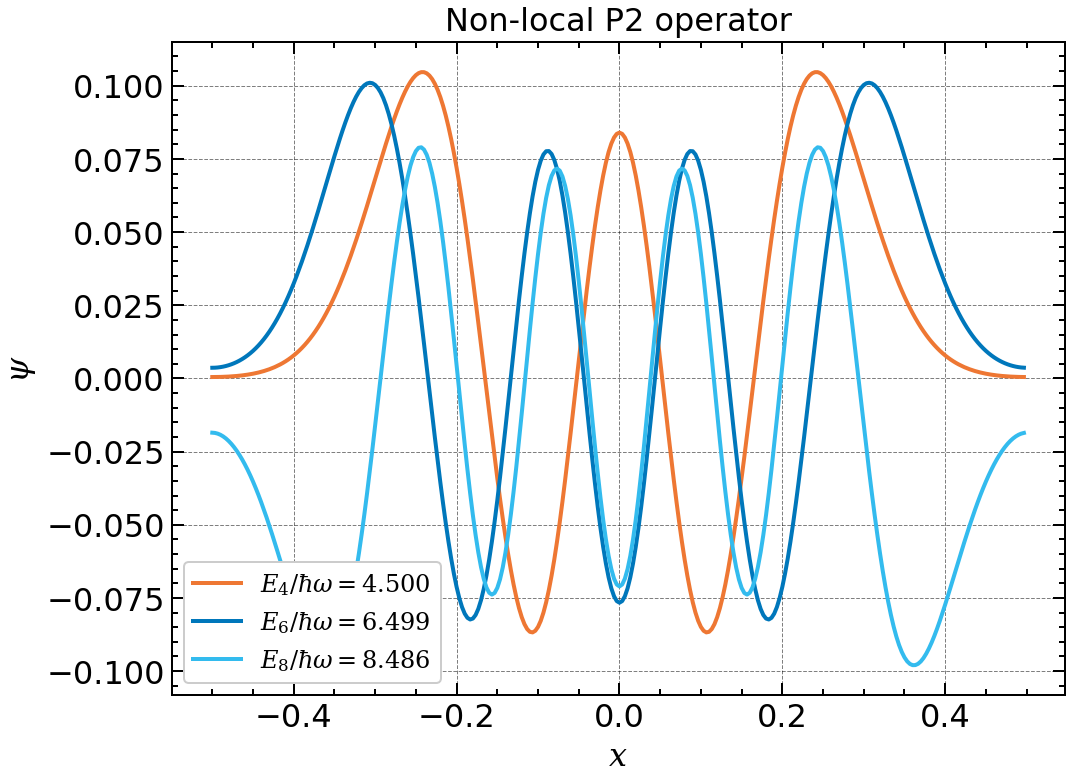

In [16]:
qm = QM_SHO_Nonlocal(L=1, N=300, omega=100)
plot_eigenfunctions([qm], [4, 6, 8])

And now we understand the cause for the discrepancies: For larger $n$ and higher energies
the particle visits positions more and more distant from the center of the harmonic
oscillator. Finally there will be an energy, for which the wave function will reach 
the ends of the discretized space and we no longer can represent the whole
wave function in the discrete space. It is no wonder that we get wrong energy
values in these cases!

## Conclusion

We have seen, that the non-local momentum operator yields perfect solutions even for very coarse 
spatial resolutions. Therefore it might be reasonable to use this operator instead of the 
local $\textbf{P2}$ operator, which on the other hand has the advantage, that we can model this
operator as an efficient *sparse* matrix. But, as written in the last post, we could use the 
[split-step method][split] to deal with the non-local operator in an effient way.

In the last part we learned, that both operators yield wrong results, once the bounded 
functions reach the end of the discrete spatial domain. So for bounded problems (like
the harmonic oscillator) one always has to make sure, that the spatial domain is large
enough, such that the wave function drops to zero at the boundaries.

[split]: https://en.wikipedia.org/wiki/Split-step_method